In [1]:
# coding: utf-8
# Our base common modules
from Common.UtilFuncs import Evaluator, Lab

# Classifiers without denoising
import Common.SvmMethod as SvmMethod

# Denoising Methodes
import Common.IsolationForestMethod as IsolationForestMethod
import Common.ConfidentLearningMethod as ConfidentLearningMethod
import Common.LocalOutlierFactorMethod as LocalOutlierFactorMethod
from Common.BERTModel import do_experiment_BERT, BERTModel

In [2]:
# The settings of the noise sources.
# Each item: source -> (size, distribution)
noisy_set_sizes0 = {
    'mislabeled' : (7600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    # 'translated' : (8600, "reserve_labels"),       # max size: 5000
}

noisy_set_sizes1 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    # 'translated' : (8600, "reserve_labels"),       # max size: 5000
}

noisy_set_sizes2 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 0),       # max size: 5000
}

noisy_set_sizes3 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 0.50),                   # max size: 5000
}

noisy_set_sizes4 = {
    # 'mislabeled' : (8600, None),                   # max size: 15000
    # 'irrelevant' : (8600, [0.25,0.25,0.25,0.25]),  # max size: 34259
    'translated' : (8600, 1),                   # max size: 5000
}

# Choose a experiment without denoising
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
experiment_without_denoising = {
    'SVM' : (SvmMethod.do_experiment, 0),
    'BERT' : (do_experiment_BERT, 1),
}

# Choose a experiment with denoising
# Each item: name -> (funcion, whether choose) note:only the first active one will be used
# experiment_with_denoising = {
#     'Confident Learning' : (do_experiment_denoised_by_ConfidentLearning, 1),
#     'Isolation Forest'   : (do_experiment_denoised_by_IsolationForest,   0),
# }

# The training set of each experiment
#origin_train_set_sizes = [2000, 4000, 5000, 8000, 10000, 15000, 20000]
origin_train_set_sizes = [15000]
# origin_train_set_sizes = [5000, 10000, 15000, 20000]
#noisy_train_set_sizes  = [(4000, 1000), (8000, 2000), (12000,3000), (15000, 5000)]
noisy_train_set_sizes  = [(12000, 3000)]

In [3]:



RUN = 1      #1/0:  Run new experiments / Read results made by previous experiments


if RUN:
    # Run new experiments
    # Initialize the lab, which will run a serial of experiments

    lab = Lab("twitter_sentiment_data_clean.csv", noisy_sources = noisy_set_sizes0, total_train_size = 20000, total_test_size = 4000, validation_size=2000)
    experiment_without_denoising['BERT'] = (do_experiment_BERT, (lab,), 1)
    lab.set_experiment_no_denoising(experiment_without_denoising)

    # Run experiment on original data
    lab.do_batch_experiments(origin_train_set_sizes)

    # Run experiment on noisy data -- mislabed noise
    lab.set_noisy_sources(noisy_set_sizes0)
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Run experiment on noisy data -- irrelevant noise
    lab.set_noisy_sources(noisy_set_sizes1)
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Run experiment on noisy data -- translated noise
    lab.set_noisy_sources(noisy_set_sizes2)
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Run experiment on noisy data -- mislabeled translated noise
    lab.set_noisy_sources(noisy_set_sizes3)
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Run experiment on noisy data -- part-mislabeled translated noise
    lab.set_noisy_sources(noisy_set_sizes4)
    lab.do_batch_experiments(noisy_train_set_sizes)

    # Save the results
    lab.save("saving/noise_effect.pk")
else:
    # Read evaluations saved by previous experiments
    lab = Lab.load("saving/noise_effect.pk")

# Show evaluations in a form
lab.print()

# Plot the evaluations
# lab.plot()

for i in range(2):
    # Plot training set size vs. Macro F1

    # x coordinate
    if i == 0:
        xValue  = "x['Origin']+x['Noise']"
        xLabel  = "Training set total size\nnoisy sets: %s" % \
                    str([str(x[0])+'+'+str(x[1]) for x in noisy_train_set_sizes]).replace("\'","")
    else:
        xValue  = "x['Origin']"
        xLabel  = "Training set origin part size\nnoisy sets: %s" % \
                    str([str(x[0])+'+'+str(x[1]) for x in noisy_train_set_sizes]).replace("\'","")

    # y coordinate
    yValue  = "y['Macro F1']"

    # Divide experiments into several groups, each will be plotted as a line
    len1 = len(origin_train_set_sizes)
    len2 = len(noisy_train_set_sizes)
    lines = { # each item: name, filter
        'Original Data':       "int((df['Experiment']-1)/%d)==0"%len1,
        'Mislabeled Noise':    "int((df['Experiment']-1-%d)/%d)==0 and df['Experiment']-1-%d>=0"%(len1,len2,len1),
        'Irrelevant Noise':    "int((df['Experiment']-1-%d)/%d)==1"%(len1,len2),
        'Translated Noise(0% mislabeled)':    "int((df['Experiment']-1-%d)/%d)==2"%(len1,len2),
        'Translated Noise(50% mislabeled)':   "int((df['Experiment']-1-%d)/%d)==3"%(len1,len2),
        'Translated Noise(100% mislabeled)':  "int((df['Experiment']-1-%d)/%d)==4"%(len1,len2),
    }

    # Do plot
    lab.Ev.plot(xValue = xValue, yValue = yValue, lines = lines,
                xLabel = xLabel, title = "SVM effected by various noises")



* 1> Training set size: 15000 samples
  Sentiments ('Anti', 'Neutral', 'Pro', 'News'): 9.4%, 18.3%, 50.2%, 22.1%


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50
938/938 [==============================] - 443s 463ms/step - loss: 0.9648 - accuracy: 0.6141 - val_loss: 0.8836 - val_accuracy: 0.6705 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 419s 447ms/step - loss: 0.7231 - accuracy: 0.7276 - val_loss: 0.7547 - val_accuracy: 0.7285 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.5050 - accuracy: 0.8160
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 404s 431ms/step - loss: 0.5050 - accuracy: 0.8160 - val_loss: 0.7701 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9412
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 405s 431ms/step - loss: 0.1621 - accuracy: 0.9412 - val_loss: 0.8573 - val_accuracy: 0.7610 - lr: 1.0000e-05
Epoch 5/50
938/938 [======================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


938/938 [==============================] - 422s 442ms/step - loss: 1.2807 - accuracy: 0.4724 - val_loss: 0.9785 - val_accuracy: 0.5405 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 434s 462ms/step - loss: 1.1583 - accuracy: 0.5565 - val_loss: 0.7870 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.9685 - accuracy: 0.6439
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 425s 453ms/step - loss: 0.9685 - accuracy: 0.6439 - val_loss: 0.7891 - val_accuracy: 0.7035 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.8112
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 410s 437ms/step - loss: 0.5510 - accuracy: 0.8112 - val_loss: 0.8051 - val_accuracy: 0.7070 - lr: 1.0000e-05
Epoch 5/50
938/938 [==============================] -

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50
938/938 [==============================] - 457s 478ms/step - loss: 0.9387 - accuracy: 0.6189 - val_loss: 0.8956 - val_accuracy: 0.6700 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 432s 460ms/step - loss: 0.6734 - accuracy: 0.7487 - val_loss: 0.7211 - val_accuracy: 0.7240 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.8227
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 426s 454ms/step - loss: 0.4941 - accuracy: 0.8227 - val_loss: 0.7947 - val_accuracy: 0.7040 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9404
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 424s 453ms/step - loss: 0.1723 - accuracy: 0.9404 - val_loss: 0.8542 - val_accuracy: 0.7520 - lr: 1.0000e-05
Epoch 5/50
938/938 [======================

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


938/938 [==============================] - 413s 432ms/step - loss: 1.0296 - accuracy: 0.5815 - val_loss: 0.9442 - val_accuracy: 0.6735 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - 403s 430ms/step - loss: 0.8107 - accuracy: 0.6856 - val_loss: 0.7889 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.6083 - accuracy: 0.7673
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 403s 430ms/step - loss: 0.6083 - accuracy: 0.7673 - val_loss: 0.8317 - val_accuracy: 0.7425 - lr: 1.0000e-04
Epoch 4/50
938/938 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9018
Epoch 4: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 426s 454ms/step - loss: 0.2592 - accuracy: 0.9018 - val_loss: 0.9345 - val_accuracy: 0.7530 - lr: 1.0000e-05
Epoch 5/50
938/938 [==============================] -

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


938/938 [==============================] - 412s 430ms/step - loss: 1.1221 - accuracy: 0.5292 - val_loss: 0.7774 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/50
938/938 [==============================] - ETA: 0s - loss: 0.9094 - accuracy: 0.6281
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
938/938 [==============================] - 403s 430ms/step - loss: 0.9094 - accuracy: 0.6281 - val_loss: 0.8009 - val_accuracy: 0.7055 - lr: 1.0000e-04
Epoch 3/50
938/938 [==============================] - ETA: 0s - loss: 0.5442 - accuracy: 0.7687
Epoch 3: ReduceLROnPlateau reducing learning rate to 1e-06.
938/938 [==============================] - 412s 439ms/step - loss: 0.5442 - accuracy: 0.7687 - val_loss: 0.7990 - val_accuracy: 0.7440 - lr: 1.0000e-05
Epoch 4/50
938/938 [==============================] - 428s 457ms/step - loss: 0.4211 - accuracy: 0.8159 - val_loss: 0.8865 - val_accuracy: 0.7515 - lr: 1.0000e-06
Epoch 5/50
938/938 [==============================] -

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
  0%|          | 0/15000 [00:00<?, ?it/s]D:\Program Files\Anaconda3\envs

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_5/tf_distil_bert_model_5/distilbert/transformer/layer_._5/attention/transpose_3' defined at (most recent call last):
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 473, in dispatch_queue
      await self.process_one()
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 462, in process_one
      await dispatch(*args)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 369, in dispatch_shell
      await result
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\kernelbase.py", line 664, in execute_request
      reply_content = await reply_content
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\ipkernel.py", line 355, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\WORK\AppData\Local\Temp\ipykernel_51856\1569753878.py", line 33, in <cell line: 4>
      lab.do_batch_experiments(noisy_train_set_sizes)
    File "e:\workspace\CS522-Project\Common\UtilFuncs.py", line 234, in do_batch_experiments
      dfResult = self.experiment(train_df, test_df, *self.experiment_params)
    File "e:\workspace\CS522-Project\Common\BERTModel.py", line 178, in do_experiment_BERT
      bert.Train(X_train_token, y_train, X_val_token, y_val)
    File "e:\workspace\CS522-Project\Common\BERTModel.py", line 93, in Train
      history = self.Model.fit(X_train,
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 573, in call
      outputs = self.distilbert(
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 415, in call
      tfmr_output = self.transformer(
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 311, in call
      for i, layer_module in enumerate(self.layer):
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 315, in call
      layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 263, in call
      sa_output = self.attention(x, x, x, attn_mask, head_mask, output_attentions, training=training)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 202, in call
      context = unshape(context)  # (bs, q_length, dim)
    File "D:\Program Files\Anaconda3\envs\tfgpu\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 180, in unshape
      return tf.reshape(tf.transpose(x, perm=(0, 2, 1, 3)), (bs, -1, self.n_heads * dim_per_head))
Node: 'model_5/tf_distil_bert_model_5/distilbert/transformer/layer_._5/attention/transpose_3'
OOM when allocating tensor with shape[16,360,12,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/tf_distil_bert_model_5/distilbert/transformer/layer_._5/attention/transpose_3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_320661]

In [4]:
len(BERTModel.sInstance)

6

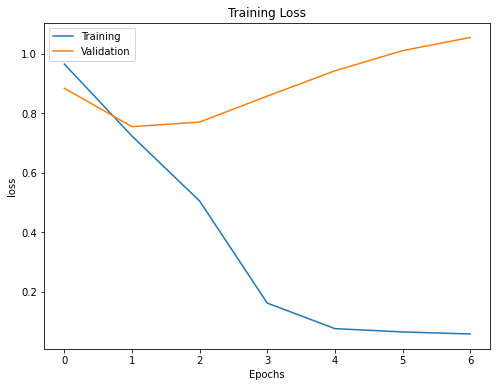

In [5]:
BERTModel.sInstance[0].PrintLoss()

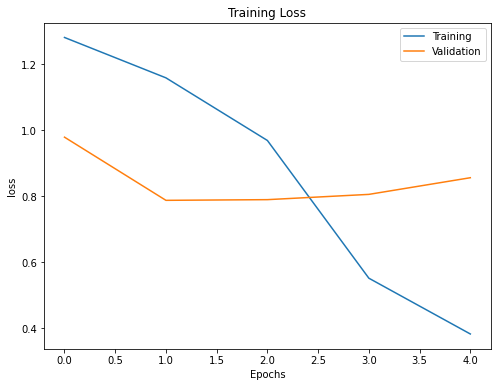

In [6]:
BERTModel.sInstance[1].PrintLoss()

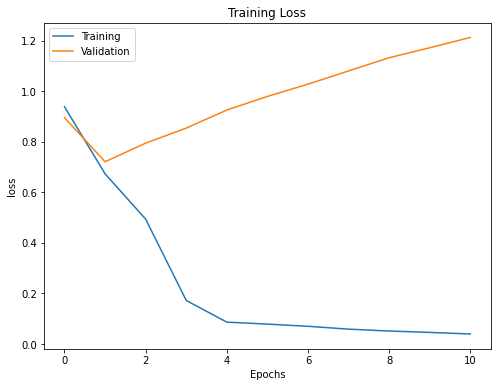

In [7]:
BERTModel.sInstance[2].PrintLoss()

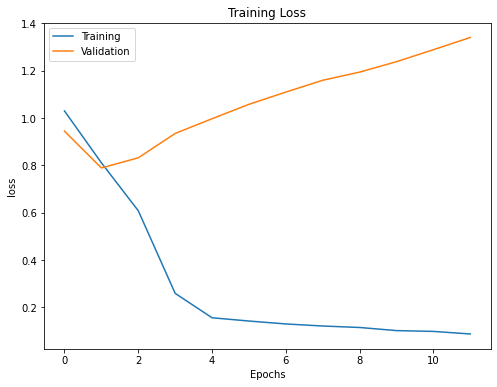

In [8]:
BERTModel.sInstance[3].PrintLoss()

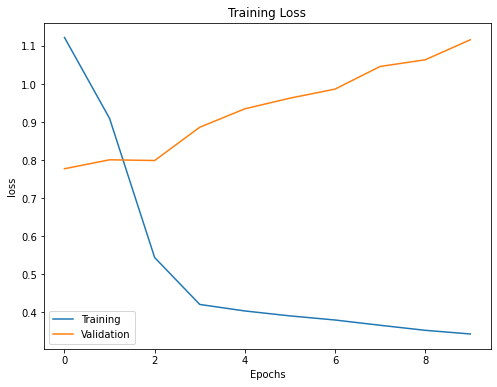

In [9]:
BERTModel.sInstance[4].PrintLoss()

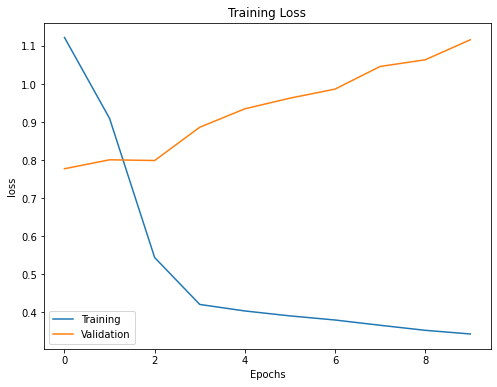

In [11]:
BERTModel.sInstance[4].PrintLoss()

In [ ]:
lab.Ev.get_evaluate().to_csv("saving/noise_effect.csv")